In [1]:
import pandas as pd
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from keras.layers import LSTM, Dense,Flatten
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from os.path import exists
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping



In [2]:
#df_failures=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_failures.csv")
#df_machines=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_machines.csv")
#df_telemetry=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_telemetry.csv")
#df_errors=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_errors.csv")
#df_failures.to_csv('equipment_failures.csv')
#df_machines.to_csv('equipment_machines.csv')
#df_telemetry.to_csv('equipment_telemetry.csv')
#df_errors.to_csv('equipment_errors.csv')

In [18]:
df_failures=pd.read_csv('equipment_failures.csv')
df_machines=pd.read_csv('equipment_machines.csv')
df_telemetry=pd.read_csv('equipment_telemetry.csv')
df_errors=pd.read_csv('equipment_errors.csv')

#print(df_machines.head())
#print(df_machines.columns)
#print(df_failures.head())
#print(df_telemetry.head())

df=pd.merge(df_telemetry,df_errors,on=['machineID','datetime'],how="left")
print(df.columns)
df=pd.merge(df,df_failures,on=['machineID','datetime'], how="left")
df=pd.merge(df,df_machines,on='machineID',how="left")

df['errorID']=df['errorID'].replace(np.nan,'No Error')
no_error=len(df[df['errorID']=='No Error'])
error=len(df[df['errorID']!='No Error'])
print("No Error",no_error)
print("Error",error)

print(len(df))
print(df.columns)


Index(['Unnamed: 0_x', 'datetime', 'machineID', 'volt', 'rotate', 'pressure',
       'vibration', 'Unnamed: 0_y', 'errorID'],
      dtype='object')


C:\Users\dnishimoto\AppData\Local\Temp\ipykernel_3168\1301743732.py:14: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df=pd.merge(df,df_machines,on='machineID',how="left")


No Error 872525
Error 3920
876445
Index(['Unnamed: 0_x', 'datetime', 'machineID', 'volt', 'rotate', 'pressure',
       'vibration', 'Unnamed: 0_y', 'errorID', 'Unnamed: 0_x', 'failure',
       'Unnamed: 0_y', 'model', 'age'],
      dtype='object')


Discover what the data looks like for the first 100 transactions


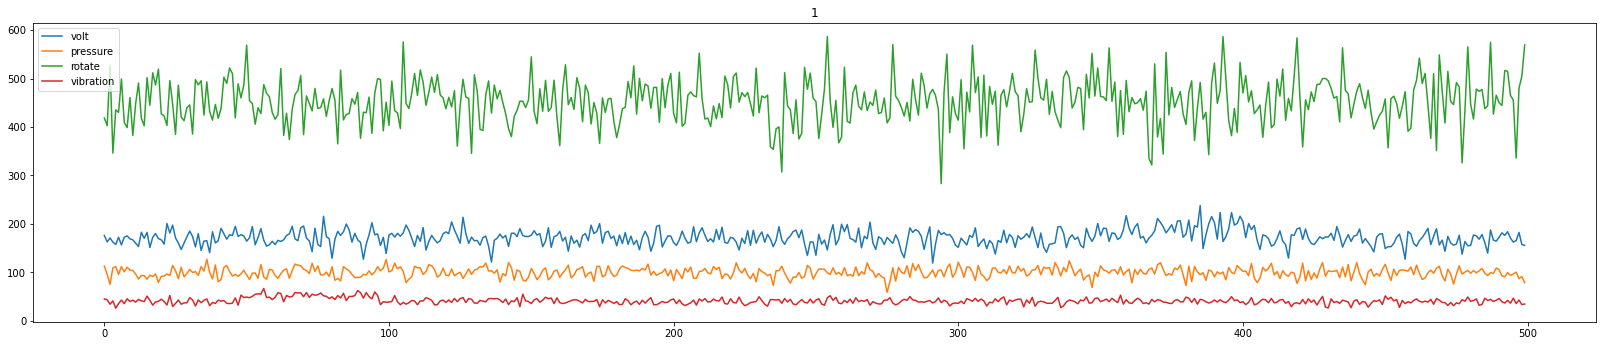

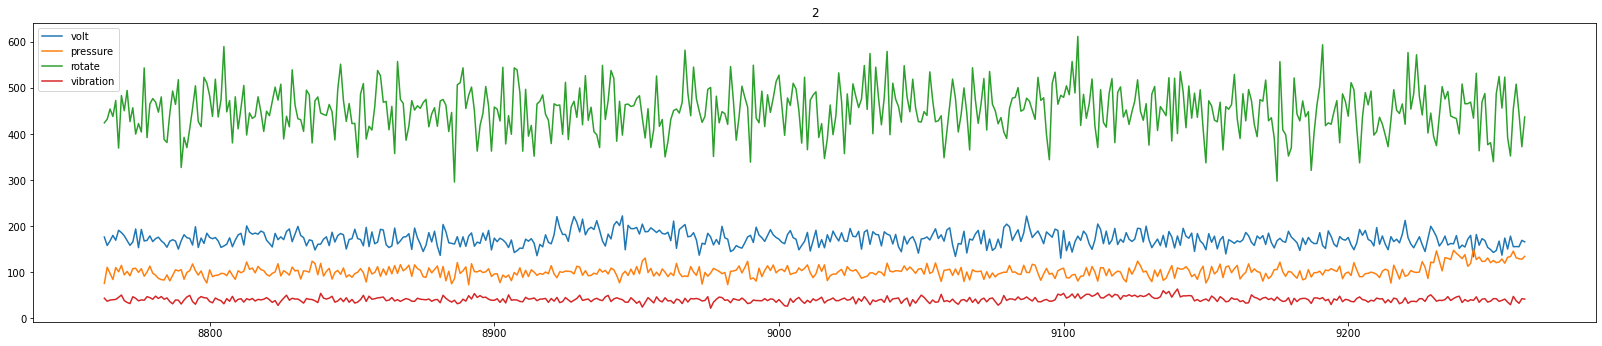

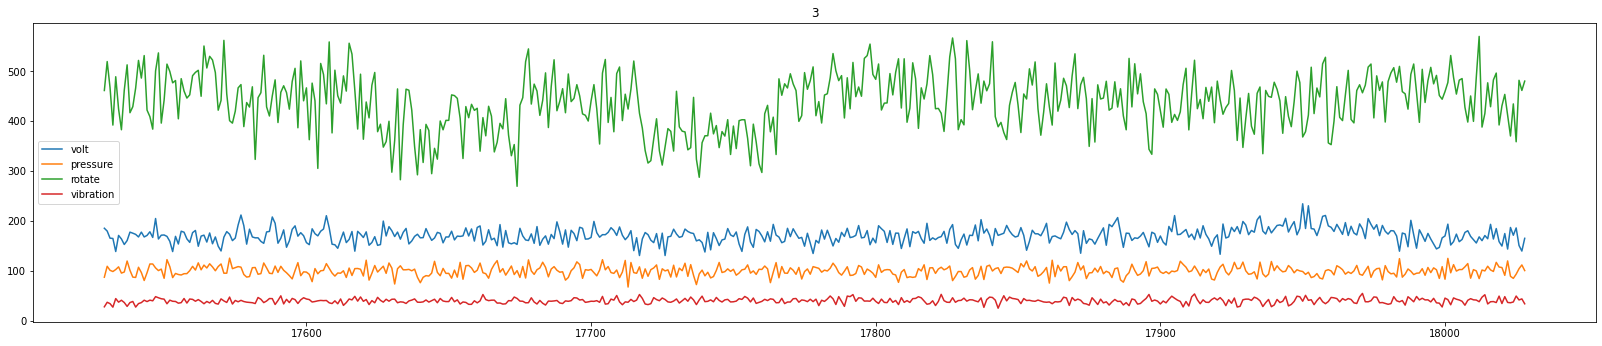

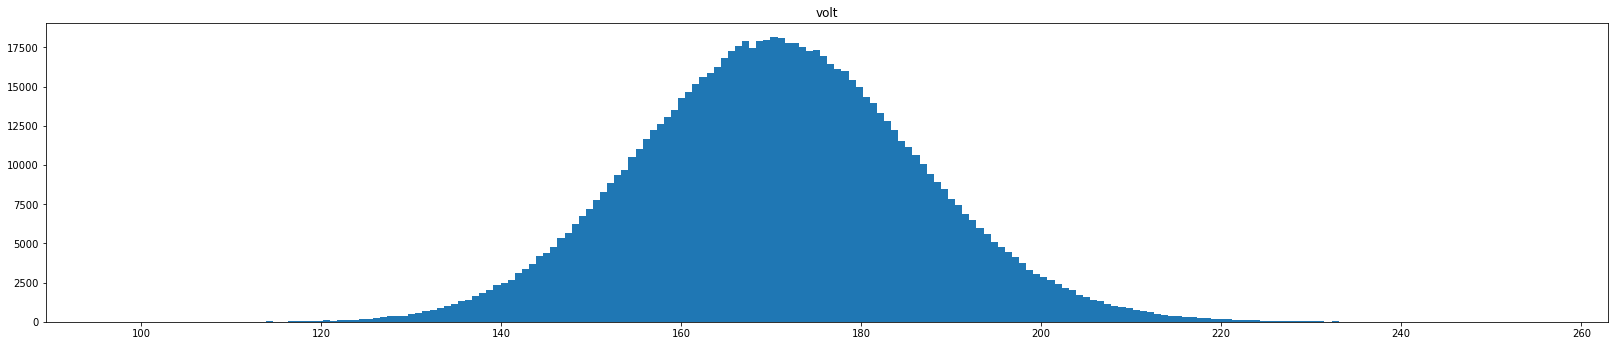

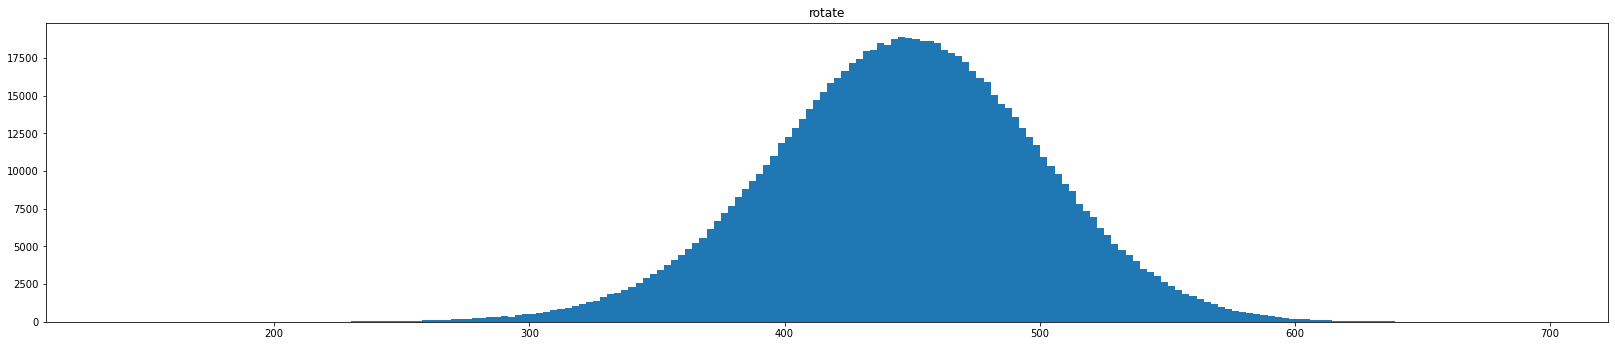

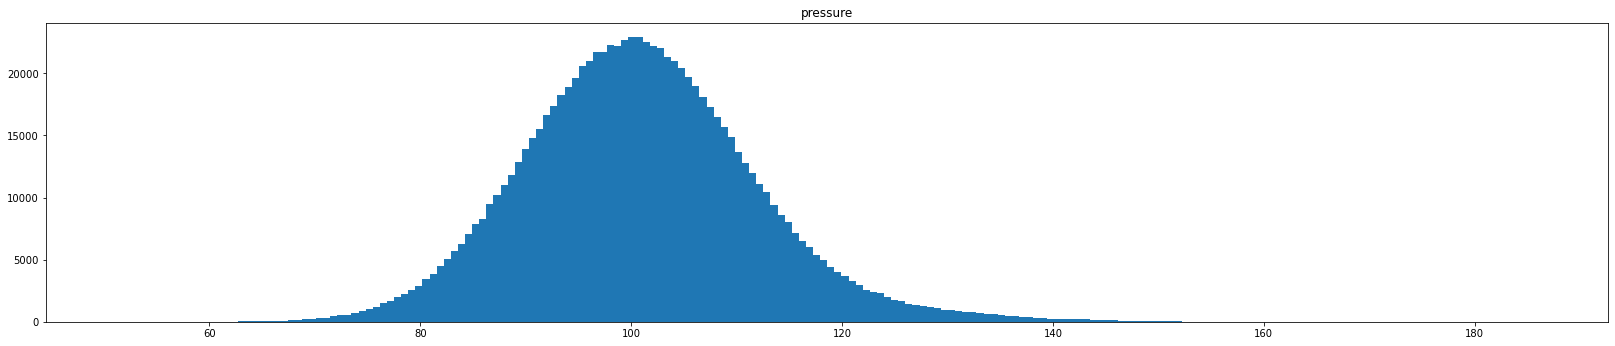

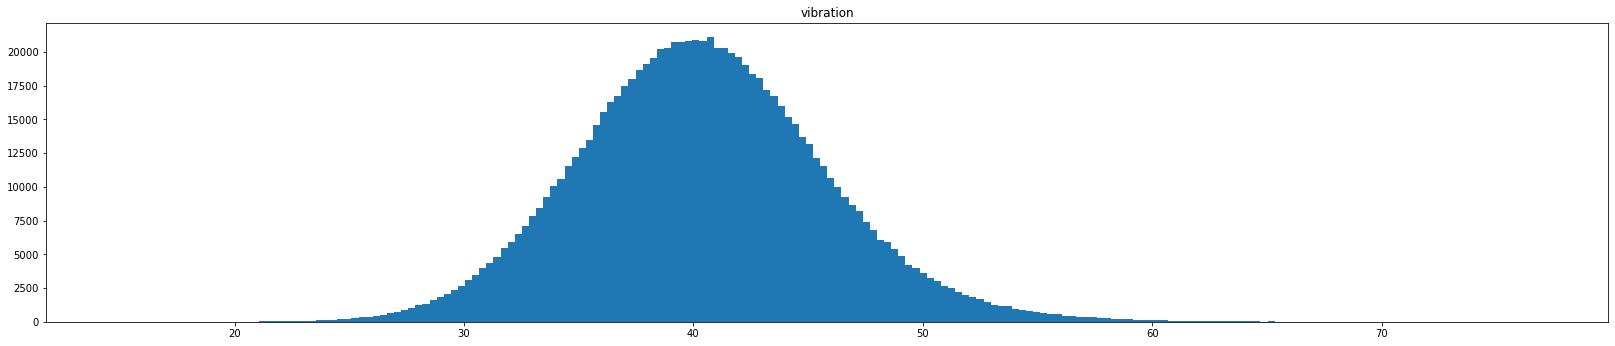

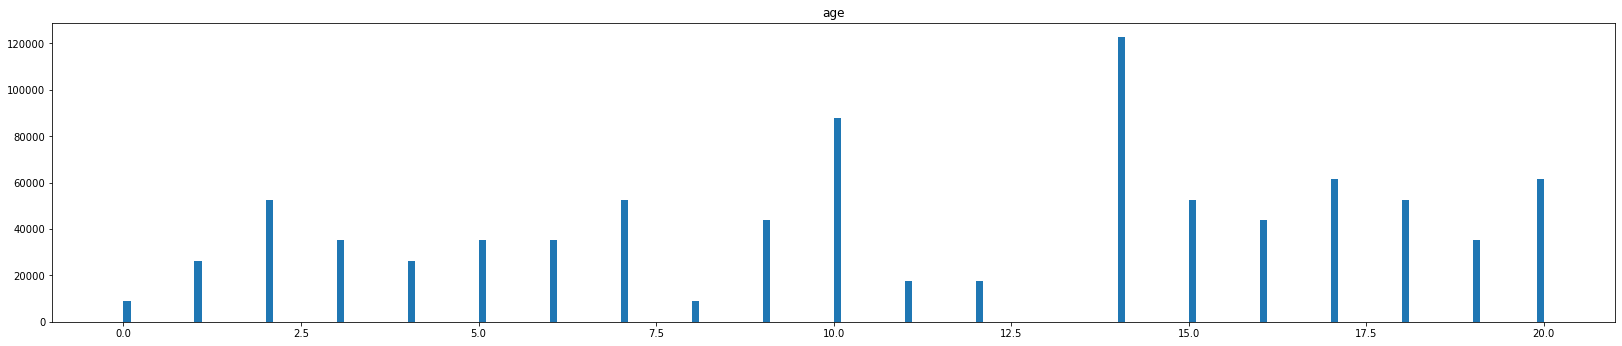

In [4]:
#'machineID', 'label', 'model', 'age', 'volt', 'rotate', 'pressure'
print("Discover what the data looks like for the first 100 transactions")
machineIds=[]
grouped=df.groupby('machineID')
for machineID in grouped:
    machineIds.append(machineID[0])

#print(machineIds)
plt.rcParams["figure.figsize"] = (28,5.5)
for machineId in machineIds[0:3]:
    #print(machineId)
    filter=df['machineID']==machineId
    results=df[filter][:500]
    #print(len(results))
    #print(results['datetime_x'])
    x=range(0,len(results)-1,1)
    plt.plot(results['volt'],label='volt')
    plt.plot(results['pressure'],label='pressure')
    plt.plot(results['rotate'],label='rotate')
    plt.plot(results['vibration'],label='vibration')
    #twin_ax=plt.twinx()
    #twin_ax.plot(results['age'],label='age')
    plt.title(machineId)
    plt.legend()
    plt.show()
    
columns=[column for column in df.columns if column in['age','vibration','rotate','pressure','volt']]
for column in columns:
    plt.hist(df[column],bins=200)
    plt.title(column)
    plt.show()



In [5]:
#'Unnamed: 0_x', 'datetime', 'machineID', 'volt', 'rotate', 'pressure',
#       'vibration', 'Unnamed: 0_y', 'errorID', 'Unnamed: 0_x', 'failure',
#       'Unnamed: 0_y', 'model', 'age'
        
print("Drop non contributing features and dummy the multi-class output")
if "datetime" in df:
    df.drop(["Unnamed: 0_x","Unnamed: 0_y","datetime","failure"],axis=1,inplace=True)
    df.rename(columns={"errorID":"label"},inplace=True)

print(df.columns)

failure_types=set(df['label'])
print(failure_types)

encoder=LabelEncoder()
df['label']=encoder.fit_transform(df['label'])
df['model']=encoder.fit_transform(df['model'])

X_columns=[x for x in df.columns if x!='label']

X=df[X_columns]
y=df['label']
#y = np.asarray(y).astype(np.float32)
y = pd.get_dummies(y)

print(y)

print(df.columns)
print(df.head(1))

Drop non contributing features and dummy the multi-class output
Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'label',
       'model', 'age'],
      dtype='object')
{'error1', 'No Error', 'error2', 'error4', 'error3', 'error5'}
        0  1  2  3  4  5
0       1  0  0  0  0  0
1       1  0  0  0  0  0
2       1  0  0  0  0  0
3       1  0  0  0  0  0
4       1  0  0  0  0  0
...    .. .. .. .. .. ..
876440  1  0  0  0  0  0
876441  1  0  0  0  0  0
876442  1  0  0  0  0  0
876443  1  0  0  0  0  0
876444  1  0  0  0  0  0

[876445 rows x 6 columns]
Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'label',
       'model', 'age'],
      dtype='object')
   machineID        volt      rotate    pressure  vibration  label  model  age
0          1  176.217853  418.504078  113.077935  45.087686      0      2   18


In [6]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

print(X_train.columns)
print("rows",X_train.shape[0],"columns",X_train.shape[1])
print((X_train.shape[0],X_train.shape[1],1))

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'model', 'age'], dtype='object')
rows 587218 columns 7
(587218, 7, 1)


In [7]:
print("build the LSTM model")
look_back=1
model = Sequential()
features=len(X_columns)
model.add(LSTM(units=100, activation='tanh', return_sequences=True, input_shape=(look_back, features),dtype="float32"))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh', return_sequences = True))
model.add(LSTM(units = 50))
model.add(Flatten())
model.add(Dense(len(y_train.columns),activation='softmax'))
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

build the LSTM model


In [8]:
print("X train shape",X_train.shape)
#print(X_train)
print("y train shape",y_train.shape)


X train shape (587218, 7)
y train shape (587218, 6)


Train the model
Epoch 1/200
1/1 [==============================] - 26s 26s/step - loss: 0.0354 - accuracy: 0.9956
Epoch 2/200
1/1 [==============================] - 24s 24s/step - loss: 0.0354 - accuracy: 0.9956
Epoch 3/200
1/1 [==============================] - 19s 19s/step - loss: 0.0354 - accuracy: 0.9956
Epoch 4/200
1/1 [==============================] - 14s 14s/step - loss: 0.0354 - accuracy: 0.9956
Epoch 5/200
1/1 [==============================] - 14s 14s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 6/200
1/1 [==============================] - 17s 17s/step - loss: 0.0354 - accuracy: 0.9956
Epoch 7/200
1/1 [==============================] - 16s 16s/step - loss: 0.0354 - accuracy: 0.9956
Epoch 8/200
1/1 [==============================] - 18s 18s/step - loss: 0.0354 - accuracy: 0.9956
Epoch 9/200
1/1 [==============================] - 18s 18s/step - loss: 0.0354 - accuracy: 0.9956
Epoch 10/200
1/1 [==============================] - 15s 15s/step - loss: 0.0354 - accuracy: 0.9956
Epo

1/1 [==============================] - 17s 17s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 84/200
1/1 [==============================] - 21s 21s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 85/200
1/1 [==============================] - 17s 17s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 86/200
1/1 [==============================] - 20s 20s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 87/200
1/1 [==============================] - 20s 20s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 88/200
1/1 [==============================] - 18s 18s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 89/200
1/1 [==============================] - 15s 15s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 90/200
1/1 [==============================] - 14s 14s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 91/200
1/1 [==============================] - 15s 15s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 92/200
1/1 [==============================] - 16s 16s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 93/200
1/1 [=====

1/1 [==============================] - 13s 13s/step - loss: 0.0352 - accuracy: 0.9956
Epoch 166/200
1/1 [==============================] - 13s 13s/step - loss: 0.0352 - accuracy: 0.9956
Epoch 167/200
1/1 [==============================] - 13s 13s/step - loss: 0.0352 - accuracy: 0.9956
Epoch 168/200
1/1 [==============================] - 12s 12s/step - loss: 0.0352 - accuracy: 0.9956
Epoch 169/200
1/1 [==============================] - 14s 14s/step - loss: 0.0352 - accuracy: 0.9956
Epoch 170/200
1/1 [==============================] - 13s 13s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 171/200
1/1 [==============================] - 12s 12s/step - loss: 0.0352 - accuracy: 0.9956
Epoch 172/200
1/1 [==============================] - 12s 12s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 173/200
1/1 [==============================] - 13s 13s/step - loss: 0.0353 - accuracy: 0.9956
Epoch 174/200
1/1 [==============================] - 14s 14s/step - loss: 0.0352 - accuracy: 0.9956
Epoch 175/200


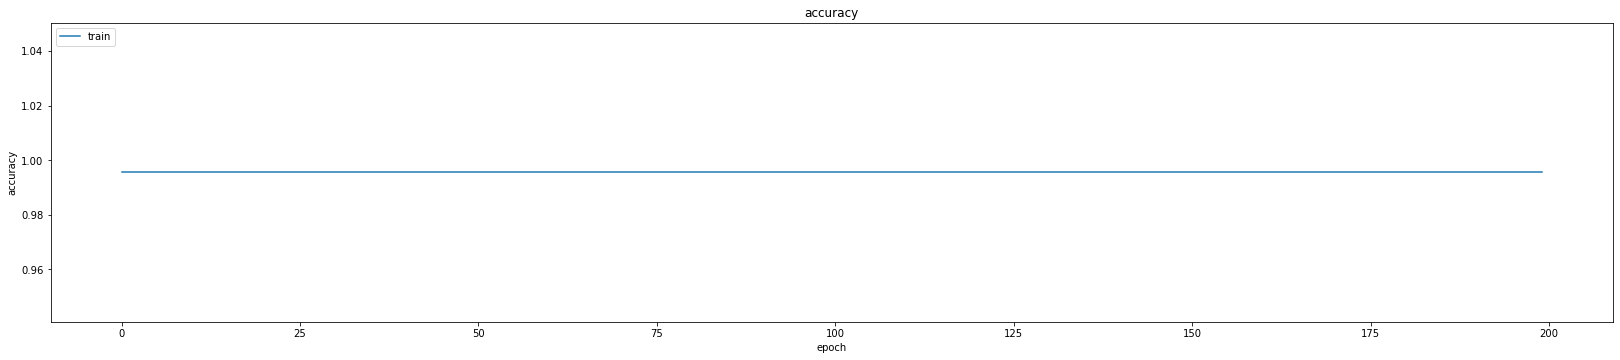

In [21]:
def plotHistory(history):
        plt.plot(history.history['accuracy'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
print ("Train the model")
length=len(X_train)
path_to_file="C:\\Users\\dnishimoto\\python_files\\python-deep-learning-master\\lstm_equipment_model.h5"

early_stopping = EarlyStopping(monitor='accuracy', patience=50)
file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
X2 = np.asarray(X_train).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y2 = np.asarray(y_train).astype(np.float32)
#history=model.fit(X2,y2,batch_size=len(X),epochs=100,verbose=1,callbacks=[early_stopping])
history=model.fit(X2,y2,batch_size=len(X),epochs=200,verbose=1)
model.save_weights(path_to_file) # can give whole path to save model
plotHistory(history)

#batch_size=1000
#start_pos=0
#look_back=1
#early_stopping = EarlyStopping(monitor='accuracy', patience=50)
#count=0
#for index in range(start_pos,length,batch_size):
#    if(index>0):
#        file_exists = exists(path_to_file)
#        if(file_exists):
#            model.load_weights(path_to_file)
            #print("loaded weights")
        
#        X2 = np.asarray(X_train[index-batch_size:index]).astype(np.float32)
#        X2 = np.resize(X2,(X2.shape[0],look_back,X2.shape[1]))
#        y2 = np.asarray(y_train[index-batch_size:index]).astype(np.float32)
#        history=model.fit(X2,y2,batch_size=len(X),epochs=500,verbose=0,callbacks=[early_stopping])
#        model.save_weights(path_to_file) # can give whole path to save model
#        #print("saved weights")
#        if (count%100000>=1):
#            print(index-batch_size,index)
#            plotHistory(history)
#        count+=1

In [22]:
print("Random select indices from the dataframe then make a prediction")
#size=len(df)
#randomlist=[]
#for i in range(0,10):
#    n = random.randint(1,size)
#    randomlist.append(n)
##print(randomlist)

#look_back=1
#X3=df[X_columns].iloc[randomlist]
#y3=df['label'].iloc[randomlist]
#y3 = pd.get_dummies(y3)

#X3 = np.asarray(X3).astype(np.float32)
#X3 = np.resize(X3,(X3.shape[0],look_back,X3.shape[1]))
#y_pred=model.predict(X3)

#lstfailure_types=next(iter(failure_types))
#for item in y_pred:
#    print("failure type",np.argmax(item))

#auc=roc_auc_score(y3, y_pred)
#print(auc)

X2 = np.asarray(X_test).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

#for item in y_pred:
#    if np.argmax(item)!=5:
#        print("failure type",np.argmax(item))

    #print(y_pred)
auc=roc_auc_score(y_test, y_pred,multi_class="ovr")
print(auc)

Random select indices from the dataframe then make a prediction
9039/9039 [==============================] - 15s 2ms/step
0.569355611889651


In [16]:
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            43200     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             30200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                                 
Total params: 93,906
Trainable params: 93,906
Non-traina